In [1]:
%cd /kaggle/working
%rm -rf /kaggle/working/*

/kaggle/working


In [2]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
import gc
from pathlib import Path
import pickle
from tqdm import tqdm
import numpy as np
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torchmetrics import MetricCollection, MeanSquaredError

sys.path.append('/kaggle/src')
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base_torch
from utils.feature_contena import Features
from utils.lightning_utils import MyLightningDataModule, MyLightningModule
from utils.postprocess import dynamic_range_nms
from torch_models.dataset import ZzzPatchDataset
from torch_models.models import ZzzTransformerGRUModel
from consts import ANGLEZ_MEAN, ANGLEZ_STD, ENMO_MEAN, ENMO_STD

MODEL_NAME = "patch_transformer_gru"

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base_torch(CFG["env"]["seed"])

BLOCK_SIZE = CFG[MODEL_NAME]["execution"]["block_size"]

2023-11-05 15:56:05.614687: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-11-05 15:56:05.614756: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-11-05 15:56:05.614760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlo

exp_121
rm: cannot remove '/kaggle/output/exp_121': No such file or directory


In [3]:
DAY_STEPS = 12 * 60 * 24

files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
dfs = []
for file in tqdm(files):
    df = pd.read_parquet(file)

    # same_count
    n_days = int(len(df) // DAY_STEPS) + 1
    df["same_count"] = 0
    for day in range(-n_days, n_days + 1):
        if day == 0:
            continue
        df["_anglez_diff"] = df["anglez"].diff(DAY_STEPS * day)
        df["_anglez_diff"] = df["_anglez_diff"].fillna(1)
        df["same_count"] += (df["_anglez_diff"] == 0).astype(int)
    df["same_count"] = (df["same_count"].clip(0, 5) - 2.5) / 2.5

    # # time    
    # timestamp = pd.to_datetime(df["timestamp"].values[0])
    # total_seconds = (timestamp - timestamp.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    # df["total_seconds"] = (total_seconds + df.index * 5) % (24 * 60 * 60)  # [sec]
    # df["total_seconds"] /= 24 * 60 * 60  # [day]

    # 標準化
    df["anglez"] = (df["anglez"] - ANGLEZ_MEAN) / ANGLEZ_STD
    df["enmo"] = (df["enmo"] - ENMO_MEAN) / ENMO_STD
    df["anglez_diff"] = df["anglez"].diff().fillna(0)
    df["enmo_diff"] = df["enmo"].diff().fillna(0)
    
    # targetは01にする
    df["onset_target"] = df["onset_target"] / 10
    df["wakeup_target"] = df["wakeup_target"] / 10
    
    dfs.append(df)
gc.collect()

100%|██████████| 277/277 [00:59<00:00,  4.66it/s]


3472

In [4]:
# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
sid2fold = dict(zip(cv_split["series_id"], cv_split["fold"]))

In [5]:
# BLOCK_SIZE ごとに分割
new_dfs = []
for df in tqdm(dfs):
    df = df.sort_values("step").reset_index(drop=True)
    df["fold"] = sid2fold[df["series_id"].values[0]]

    for start in range(0, len(df), BLOCK_SIZE // 8):
        end = start + BLOCK_SIZE
        if end > len(df):
            # endをlen(df)未満の最大のpsの倍数にする
            end = len(df) - len(df) % CFG[MODEL_NAME]["execution"]["patch_size"]
            start = end - BLOCK_SIZE
            assert start >= 0
        assert df.iloc[start]["step"] % CFG[MODEL_NAME]["execution"]["patch_size"] == 0
        new_dfs.append(df.iloc[start: end])
dfs = new_dfs
gc.collect()

features = Features()
features.add_num_features(["anglez", "enmo"])
features.add_num_features(["anglez_diff", "enmo_diff"])
features.add_num_features(["same_count"])
# features.add_num_features(["total_seconds"])
dataset_oof = ZzzPatchDataset(dfs, 'train', features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
feats, targets = dataset_oof[0]
feats.shape, targets.shape

  0%|          | 0/277 [00:00<?, ?it/s]

100%|██████████| 277/277 [00:17<00:00, 15.81it/s]


((1600, 60), (1600, 2))

In [6]:
!rm -r logs

rm: cannot remove 'logs': No such file or directory


In [7]:
%%time

fold_oof_dfs = []
for fold in range(5):
    print(f"== fold {fold} ==")
    
    # 学習・評価データ
    train_dfs = [df for df in dfs if df["fold"].unique()[0] != fold]
    valid_dfs = [df for df in dfs if df["fold"].unique()[0] == fold]
    train_dataset = ZzzPatchDataset(train_dfs, mode="train", features=features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
    valid_dataset = ZzzPatchDataset(valid_dfs, mode="train", features=features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
    data_module = MyLightningDataModule(train_dataset, valid_dataset, batch_size=32)

    # モデル
    num_training_steps = len(train_dataset) // 32 * 10
    
    model = ZzzTransformerGRUModel(
        max_len=BLOCK_SIZE // CFG[MODEL_NAME]["execution"]["patch_size"],
        input_numerical_size=len(features.all_features()) * CFG[MODEL_NAME]["execution"]["patch_size"],
        **CFG[MODEL_NAME]["params"],
    )
    pl_model = MyLightningModule(
        model=model,
        lr=0.0005, 
        loss_fn=nn.BCEWithLogitsLoss(),
        num_training_steps=num_training_steps,
    )
    
    # コールバック
    cp_callback = ModelCheckpoint(
        "logs/", 
        filename=f"best_model_fold{fold}",
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        save_last=False,
    )
    es_callback = EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=4,
    )

    # 学習
    trainer = pl.Trainer(
        callbacks=[cp_callback, es_callback],
        deterministic=True,
        val_check_interval=0.25,
        )
    trainer.fit(pl_model, datamodule=data_module)

    # 推論
    pl_model = MyLightningModule.load_from_checkpoint(
        f"logs/best_model_fold{fold}.ckpt", 
        model=model,
    ).to("cuda")
    pl_model.eval()
    preds = []
    with torch.no_grad():
        for X, y in data_module.val_dataloader():
            pred = torch.sigmoid(pl_model(X.to("cuda"))).detach().cpu().numpy() * 10
            preds.append(pred)

    oof_dfs = []
    for pred, df in zip(np.vstack(preds), valid_dfs):
        df = df.iloc[CFG[MODEL_NAME]["execution"]["patch_size"] // 2: len(df): CFG[MODEL_NAME]["execution"]["patch_size"]].reset_index(drop=True)
        df[["wakeup_oof", "onset_oof"]] = pred
        oof_dfs.append(df)

    oof_df = pd.concat(oof_dfs)
    oof_df = oof_df.groupby(["series_id", "step"]).mean().reset_index().sort_values(["series_id", "step"])
    fold_oof_dfs.append(oof_df[["series_id", "step", "wakeup_oof", "onset_oof"]])

    del model, preds, oof_df, oof_dfs
    gc.collect()
    # break
train = pd.concat(fold_oof_dfs)
train.to_parquet(f"{CFG['output_dir']}/oof.parquet", index=False)
del fold_oof_dfs
gc.collect()

== fold 0 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.7120, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0230, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0097, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0078, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0075, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0073, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0072, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0072, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0073, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0074, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0072, 
== fold 1 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.6628, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0202, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0089, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0067, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0062, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0060, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0060, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0059, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0058, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0059, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0058, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0059, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0059, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0061, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0062, 
== fold 2 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.9197, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0229, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0137, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0082, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0075, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0073, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0074, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0072, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0071, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0071, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0071, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0071, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0073, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0072, 
== fold 3 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.6357, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0222, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0105, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0083, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0078, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0077, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0076, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0075, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0074, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0075, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0076, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0075, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0076, 
== fold 4 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.7862, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0231, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0119, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0085, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0077, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0076, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0076, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0076, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0073, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0074, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0074, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0074, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0074, 
CPU times: user 3h 28min 38s, sys: 5min 21s, total: 3h 34min
Wall time: 1h 36min 45s


0

1395298

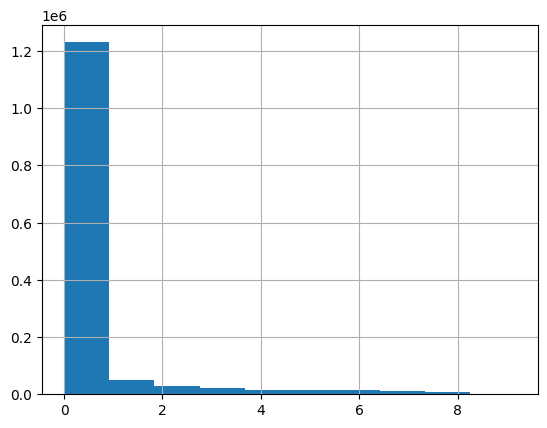

In [8]:
dfs = []
df = train[["series_id", "step", "wakeup_oof"]].copy()
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = train[["series_id", "step", "onset_oof"]].copy()
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs)
train = train[train["score"]>0.005].reset_index(drop=True)
train["score"].hist()
len(train)

## Dynamic-Range NMS

In [9]:
train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:06<00:00, 41.88it/s]


In [10]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
labels = labels[labels["series_id"].isin(sub["series_id"].unique())]
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

score: 0.7925


event   tolerance
onset   12           0.344387
        36           0.702792
        60           0.782137
        90           0.817958
        120          0.843816
        150          0.856986
        180          0.870555
        240          0.882666
        300          0.889133
        360          0.895772
wakeup  12           0.388710
        36           0.711345
        60           0.789010
        90           0.818582
        120          0.843276
        150          0.853624
        180          0.868540
        240          0.885290
        300          0.898138
        360          0.906542
dtype: float64

In [11]:
%cp -r logs {CFG["output_dir"]}